In [2]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import random
import pandas as pd

Step 1: Get HCMC Road Network

In [3]:
# Define city boundary

city = "Ho Chi Minh City, Vietnam"
FILE_NAME = "hcmc_road_network.graphml"

city_gdf = ox.geocode_to_gdf(city)
city_polygon = city_gdf.iloc[0].geometry

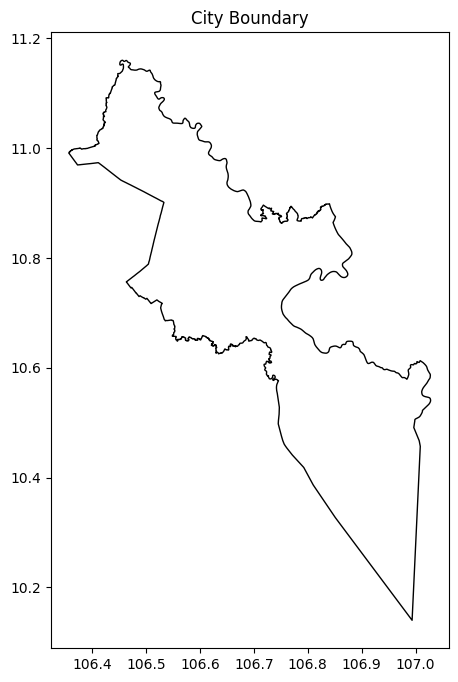

In [4]:
# (Optional) Plot the city boundary
ax = city_gdf.plot(facecolor="none", edgecolor="black", figsize=(8,8))
plt.title("City Boundary")
plt.show()

Extract Commercial Zones & Compute Parcel Locker Locations

In [11]:
# Define tag for commercial zones
commercial_tags = {'landuse': 'commercial'}

# Use the features module to get commercial geometries within the city polygon
commercial = ox.features.features_from_polygon(city_polygon, tags=commercial_tags)

# Filter for polygon geometries (ignore points/lines)
commercial = commercial[commercial.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Reproject to a suitable projected CRS (units in meters) for accurate centroid calculation
commercial_proj = ox.projection.project_gdf(commercial)

# Compute centroids in the projected CRS
commercial_proj['centroid'] = commercial_proj.geometry.centroid

# Reproject centroids back to geographic (EPSG:4326) for further use and plotting
parcel_lockers = commercial_proj.copy()
parcel_lockers['centroid'] = commercial_proj['centroid'].to_crs(epsg=4326)

# Set the geometry of the GeoDataFrame to these centroids
parcel_lockers = parcel_lockers.set_geometry('centroid')

# (Optional) Plot commercial zones and parcel locker locations
fig, ax = plt.subplots(figsize=(8,8))
commercial.to_crs(epsg=4326).plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=1.0)
parcel_lockers.plot(ax=ax, color="red", markersize=50)
plt.title("Commercial Zones & Candidate Parcel Locker Locations")
plt.show()

InsufficientResponseError: No matching features. Check query location, tags, and log.

In [48]:
parcel_lockers.head()

geometry  \
element  id                                                             
relation 12438355   POLYGON ((682993.212 1197858.885, 682994.13 11...   
way      165420596  POLYGON ((686067.583 1192908.191, 686072.333 1...   
         165567719  POLYGON ((685824.179 1192496.778, 685850.007 1...   
         186275007  POLYGON ((685908.035 1192084.893, 685926.145 1...   
         186275012  POLYGON ((685824.179 1192496.778, 685748.969 1...   

                       landuse                          name      office  \
element  id                                                                
relation 12438355   commercial                           NaN         NaN   
way      165420596  commercial  Đài Truyền hình TP.HCM (HTV)         NaN   
         165567719  commercial      Tổng Lãnh sự quán Hoa Kỳ  diplomatic   
         186275007  commercial        Sở Văn hoá và Thể thao         NaN   
         186275012  commercial        Tổng Lãnh sự quán Pháp  diplomatic   

                           addr:city addr:district addr:housenumber  \
element  id                                                           
relation 12438355                NaN           NaN              NaN   
way      165420596  Ho Chi Minh City        Quận 1                9   
         165567719               NaN           NaN                4   
         186275007               NaN           NaN              164   
         186275012  Ho Chi Minh City        Quận 1               27   

                            addr:province             addr:street  \
element  id                                                         
relation 12438355                     NaN                     NaN   
way      165420596  Thành phố Hồ Chí Minh  Nguyễn Thị Minh Khai   
         165567719                    NaN                 Lê Duẩn   
         186275007                    NaN               Đồng Khởi   
         186275012                    NaN    Nguyễn Thị Minh Khai   

                   addr:subdistrict  ... description image phone start_date  \
element  id                          ...                                      
relation 12438355               NaN  ...         NaN   NaN   NaN        NaN   
way      165420596  Phường Bến Nghé  ...         NaN   NaN   NaN        NaN   
         165567719              NaN  ...         NaN   NaN   NaN        NaN   
         186275007              NaN  ...         NaN   NaN   NaN        NaN   
         186275012         Bến Nghé  ...         NaN   NaN   NaN        NaN   

                   opening_date name:ja operator:wikidata mobile  \
element  id                                                        
relation 12438355           NaN     NaN               NaN    NaN   
way      165420596          NaN     NaN               NaN    NaN   
         165567719          NaN     NaN               NaN    NaN   
         186275007          NaN     NaN               NaN    NaN   
         186275012          NaN     NaN               NaN    NaN   

                            type                    centroid  
element  id                                                   
relation 12438355   multipolygon  POINT (106.67424 10.83176)  
way      165420596           NaN  POINT (106.70263 10.78678)  
         165567719           NaN  POINT (106.70027 10.78309)  
         186275007           NaN  POINT (106.70052 10.77881)  
         186275012           NaN  POINT (106.69919 10.78262)  

[5 rows x 69 columns]

In [ ]:
# Filter out parcel lockers without a name
parcel_lockers.dropna(subset=['name'], inplace=True)
# Filter out government and diplomatic buildings in "office" col
parcel_lockers = parcel_lockers[~parcel_lockers['office'].isin(['government', 'diplomatic'])]
# Only select the 'name' and 'geometry', centroid columns
parcel_lockers = parcel_lockers[['name', 'centroid', 'geometry']]
print("Number of candidate parcel locker locations:", len(parcel_lockers))
parcel_lockers.head()

Extract Residential Areas & Generate Synthetic Customers via Poisson Process

In [57]:
# Define tag for residential areas
residential_tags = {'landuse': 'residential'}

# Get residential geometries within the city polygon
residential = ox.features.features_from_polygon(city_polygon, tags=residential_tags)

# Reproject residential areas to a projected CRS for accurate area calculations
residential_proj = ox.projection.project_gdf(residential)

# Define an average customer density (customers per square meter)
density = 1e-6  # Adjust this value as needed

# Helper function: sample a random point inside a polygon (in projected CRS)
def random_point_in_poly(poly):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p

# Generate synthetic customers uniformly in each residential polygon
synthetic_customers = []
for idx, row in residential_proj.iterrows():
    poly = row.geometry
    area = poly.area
    # Number of customers follows a Poisson distribution with mean proportional to area
    n_customers = np.random.poisson(density * area)
    for _ in range(n_customers):
        pt = random_point_in_poly(poly)
        synthetic_customers.append(pt)

# Create a GeoDataFrame for these customers (still in projected CRS)
customers_proj = gpd.GeoDataFrame(geometry=synthetic_customers, crs=residential_proj.crs)
# Reproject customers back to geographic CRS for consistency with other data
customers = customers_proj.to_crs(epsg=4326)
customers.head()

,geometry
0,POINT (106.65534 10.74858)
1,POINT (106.71274 10.72999)
2,POINT (106.75018 10.79674)
3,POINT (106.79708 10.80511)
4,POINT (106.72231 10.79371)


Generate Customer Clusters Around Parcel Lockers Using Gaussian Offsets

In [58]:
# Cell: Generate Customer Clusters Around Parcel Lockers Using Gaussian Offsets

# Parameters for clustering:
cluster_mean = 20      # average additional customers per locker cluster
cluster_std = 0.005    # standard deviation for Gaussian offset (in degrees, if using geographic CRS)

cluster_customers = []
for idx, row in parcel_lockers.iterrows():
    geom = row.geometry
    # If the candidate locker geometry is not a Point, use its centroid.
    if not isinstance(geom, Point):
        locker_pt = row.centroid
    else:
        locker_pt = geom
    # Draw number of clustered customers using a Poisson distribution
    n_cluster = np.random.poisson(cluster_mean)
    for _ in range(n_cluster):
        offset_x, offset_y = np.random.normal(0, cluster_std, 2)
        clustered_pt = Point(locker_pt.x + offset_x, locker_pt.y + offset_y)
        cluster_customers.append(clustered_pt)

target_crs = customers.crs  # assuming customers were reprojected to EPSG:4326
# Create a GeoDataFrame for clustered customers
cluster_customers_gdf = gpd.GeoDataFrame(geometry=cluster_customers, crs=target_crs)
cluster_customers_gdf.head()

,geometry
0,POINT (106.69226 10.78893)
1,POINT (106.70016 10.78481)
2,POINT (106.70541 10.79234)
3,POINT (106.704 10.7938)
4,POINT (106.70615 10.78072)


Combine Customers & Assign Randomized Demand Levels

In [59]:
# Combine uniformly distributed customers with clustered customers
all_customers = pd.concat([customers, cluster_customers_gdf], ignore_index=True)

# Assign a random demand level (e.g., between 1 and 10)
all_customers['demand'] = np.random.uniform(1, 10, size=len(all_customers))

# (Optional) View head of the customer GeoDataFrame
# Number of customers
print(len(all_customers))
all_customers.head()

1659


,geometry,demand
0,POINT (106.65534 10.74858),1.484875
1,POINT (106.71274 10.72999),5.231603
2,POINT (106.75018 10.79674),6.202087
3,POINT (106.79708 10.80511),3.082501
4,POINT (106.72231 10.79371),2.132295


/tmp/ipykernel_2890457/997232095.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


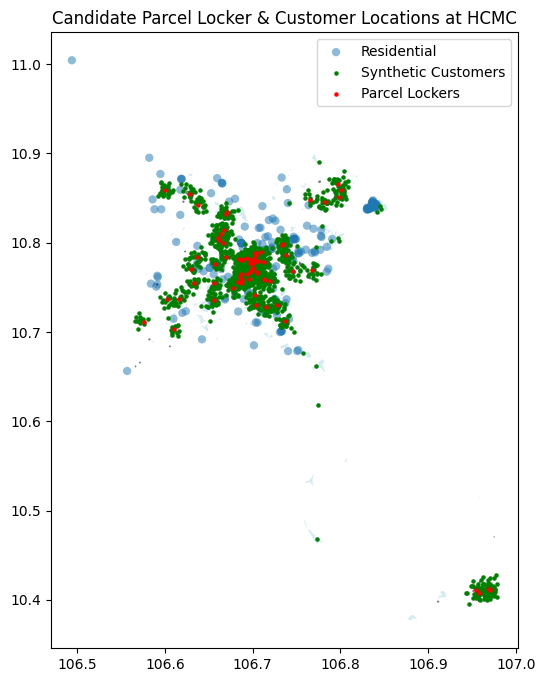

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
# Plot residential areas (in geographic CRS)
residential.to_crs(epsg=4326).plot(ax=ax, facecolor='lightblue', edgecolor='none', alpha=0.5, label="Residential")
# Plot commercial zones
commercial.to_crs(epsg=4326).plot(ax=ax, facecolor='lightgray', edgecolor='black', alpha=0.5, label="Commercial")
# Plot synthetic customer locations
all_customers.plot(ax=ax, color='green', markersize=5, label="Synthetic Customers")
# Plot parcel locker candidate locations (centroids)
parcel_lockers.plot(ax=ax, color='red', markersize=5, label="Parcel Lockers")
plt.legend()
plt.title("Candidate Parcel Locker & Customer Locations at HCMC")
plt.show()

Store the data

In [62]:
# Save the data into .csv files
all_customers.to_csv("all_customers.csv")
parcel_lockers.to_csv("parcel_lockers.csv")